In [35]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import sys

# Config

In [43]:
HYPER_OPT = False 
HYPER_OPT_TIME = 3600*5
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False
AUTOGLUON_TIME = 3600*11
RETRAIN = False
STACK_LEVELS = 2

In [37]:
# Define the base directory (where the notebook is running)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Define the data directory
data_dir = os.path.join(base_dir, "data")

model_dir = os.path.join(base_dir, "models")

sys.path.append(base_dir)

# Data Extraction

In [38]:
from axyom_utilities.data_extraction import extract_data

X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA)

In [39]:
X_train["Premium Amount"] = y_train # for autogluon

# Data Cleaning

In [40]:
from axyom_utilities.preprocessing import preprocess 

X_train = preprocess(X_train)
X_test = preprocess(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocess(X_orig)

# Model Training

In [10]:
from autogluon.tabular import TabularDataset, TabularPredictor
from datetime import datetime


# Initialize a CatBoost Regressor
if RETRAIN:
    predictor = TabularPredictor(
        problem_type='regression',
        eval_metric='rmse',
        label="Premium Amount",
        #groups='fold',
        verbosity=2
    )
else:
    # Load the existing predictor
    predictor = TabularPredictor.load("AutogluonModels/ag-20241212_033419")

    # Generate the unique directory name in the desired format: ag-YYYYMMDD_HHMMSS
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
    new_directory = f"AutogluonModels/ag-{current_time}"

    # Save the predictor to the new directory
    predictor.save(new_directory)

    # Verify the new save path
    print(f"Predictor saved to: {new_directory}")

    

No path specified. Models will be saved in: "AutogluonModels\ag-20241212_033419"


In [ ]:
predictor.fit(
    train_data=X_train,
    time_limit=AUTOGLUON_TIME,
    presets='best_quality',
    excluded_model_types=['KNN', 'NN_TORCH', 'FASTAI', 'RF'],
    ag_args_fit={'num_gpus': 1},
    num_stack_levels=STACK_LEVELS
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       4.52 GB / 15.82 GB (28.6%)
Disk Space Avail:   223.20 GB / 930.65 GB (24.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up t

In [ ]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

In [27]:
leaderboard = predictor.leaderboard(silent=True)

In [28]:
predictor.plot_ensemble_model()

'c:\\Users\\Axyom\\Kaggle\\PG S4e12 - Regression Insurance\\notebooks\\AutoGluon\\AutogluonModels\\ag-20241212_033419\\ensemble_model.png'

In [29]:
best_model_name = predictor.model_best

In [10]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

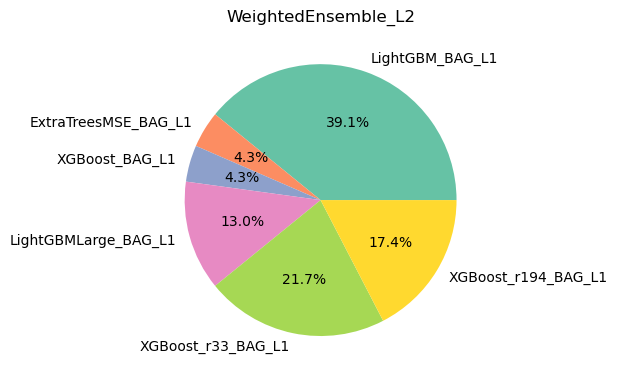

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [ ]:
best_model_score = -leaderboard[leaderboard['model'] == best_model_name]['score_val'].values[0]
print(f"Best Model: {best_model_name}")
print(f"Validation Score: {best_model_score}")

In [41]:
test_preds = predictor.predict(X_test)

In [ ]:
# import joblib

# # Save OOF predictions as a CSV file
# oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
# oof_preds_df.to_csv("oof_preds", index=False)
# print("OOF predictions saved to oof_preds.csv.")

# test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
# test_preds_df.to_csv("test_preds", index=False)
# print("Test predictions saved to test_preds.csv.")

# joblib.dump(results["models"], "xgboost_models.pkl")

# Submission

In [42]:
y_pred = np.expm1(test_preds)

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = f"cleaning_autogluon_submission_{best_model_score:.4f}.csv"

submission.to_csv(FILE_PATH, index=False)

In [44]:
import os

# Define your message and file paths
COMP_NAME = "playground-series-s4e12"

SUBMIT_MESSAGE = f"Clean XGB: Mean score: {best_model_score:.4f}"

# Submit to Kaggle

if SUBMIT_TO_KAGGLE: 
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')

In [ ]:
# import os
# from IPython.display import display, Javascript

# # Define your message and file paths
# COMP_NAME = "playground-series-s4e12"
# FILE_PATH = "submission.csv"

# SUBMIT_MESSAGE = f"Clean XGB: Mean score: {mean_score:.4f} +/- {std_score:.4f}"

# # Submit to Kaggle
# if SUBMIT_TO_KAGGLE: 
#     os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')

# # Git commit and push
# GIT_COMMIT_MESSAGE = f"Submission: {SUBMIT_MESSAGE}"

# # save notebook
# # display(Javascript('IPython.notebook.save_checkpoint()'))

# # Commands for Git
# os.system("git add .")  # Stage all changes (adjust if you only want specific files)
# os.system(f'git commit -m "{GIT_COMMIT_MESSAGE}"')  # Commit changes with a message
# os.system("git push origin main")  # Push to the main branch (change branch if needed)